In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-03

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

cm_threshold = 0.1

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x = np.hstack((t, hh, bb, total_coords))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [10]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [11]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [12]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>cm_threshold:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [13]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [14]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [15]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [16]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [17]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 113)
Dimension - y:  (80000, 1)


In [18]:
def dataset_split(x, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate),  random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = dataset_split(x, y, test_rate, val_rate=val_rate, validation=True, random_state=26)

In [20]:
y_train

array([[0.00024265],
       [0.00104693],
       [0.00118191],
       ...,
       [0.00120976],
       [0.00116875],
       [0.00103772]])

In [21]:
def make_mlp_model(num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=(x_train.shape[1]))

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [22]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 256)               29184     
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [24]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [25]:
ckpt_name = model_directory + "20221218unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-09,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-10, min_lr=1e-06, verbose=1)

In [26]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [27]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.4949 - rmse: 0.1399
Epoch 1: val_loss improved from inf to 2.38118, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 2s 11ms/step - loss: 2.4910 - rmse: 0.1374 - val_loss: 2.3812 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 2/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3033 - rmse: 0.0100
Epoch 2: val_loss improved from 2.38118 to 2.21245, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 6ms/step - loss: 2.2972 - rmse: 0.0097 - val_loss: 2.2124 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 3/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.1377 - rmse: 0.0052
Epoch 3: val_loss improved from 2.21245 to 2.05668, saving model to D:\TrainedModels\2022121820221218unste

55/55 [==============================] - 0s 8ms/step - loss: 0.6840 - rmse: 0.0035 - val_loss: 0.6669 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 22/10000
54/55 [============================>.] - ETA: 0s - loss: 0.6514 - rmse: 0.0034
Epoch 22: val_loss improved from 0.66686 to 0.63531, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.6511 - rmse: 0.0034 - val_loss: 0.6353 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 23/10000
54/55 [============================>.] - ETA: 0s - loss: 0.6211 - rmse: 0.0037
Epoch 23: val_loss improved from 0.63531 to 0.60626, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.6208 - rmse: 0.0038 - val_loss: 0.6063 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 24/10000
55/55 [==============================] 

Epoch 42/10000
55/55 [==============================] - ETA: 0s - loss: 0.3253 - rmse: 0.0026
Epoch 42: val_loss improved from 0.32938 to 0.32120, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.3253 - rmse: 0.0026 - val_loss: 0.3212 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 43/10000
46/55 [========================>.....] - ETA: 0s - loss: 0.3179 - rmse: 0.0037
Epoch 43: val_loss improved from 0.32120 to 0.31337, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.3173 - rmse: 0.0035 - val_loss: 0.3134 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 44/10000
47/55 [========================>.....] - ETA: 0s - loss: 0.3101 - rmse: 0.0034
Epoch 44: val_loss improved from 0.31337 to 0.30585, saving model to D:\TrainedModels\202212182022

55/55 [==============================] - 0s 8ms/step - loss: 0.2055 - rmse: 0.0019 - val_loss: 0.2032 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 63/10000
55/55 [==============================] - ETA: 0s - loss: 0.2009 - rmse: 0.0037
Epoch 63: val_loss improved from 0.20324 to 0.19867, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.2009 - rmse: 0.0037 - val_loss: 0.1987 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 64/10000
54/55 [============================>.] - ETA: 0s - loss: 0.1964 - rmse: 0.0029
Epoch 64: val_loss improved from 0.19867 to 0.19417, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.1964 - rmse: 0.0029 - val_loss: 0.1942 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 65/10000
55/55 [==============================] 

Epoch 83/10000
55/55 [==============================] - ETA: 0s - loss: 0.1226 - rmse: 0.0036
Epoch 83: val_loss improved from 0.12431 to 0.12097, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.1226 - rmse: 0.0036 - val_loss: 0.1210 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 84/10000
55/55 [==============================] - ETA: 0s - loss: 0.1193 - rmse: 0.0026
Epoch 84: val_loss improved from 0.12097 to 0.11768, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.1193 - rmse: 0.0026 - val_loss: 0.1177 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 85/10000
55/55 [==============================] - ETA: 0s - loss: 0.1160 - rmse: 0.0011
Epoch 85: val_loss improved from 0.11768 to 0.11444, saving model to D:\TrainedModels\202212182022

55/55 [==============================] - 0s 8ms/step - loss: 0.0661 - rmse: 0.0026 - val_loss: 0.0650 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 104/10000
55/55 [==============================] - ETA: 0s - loss: 0.0639 - rmse: 0.0025
Epoch 104: val_loss improved from 0.06503 to 0.06277, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.0639 - rmse: 0.0025 - val_loss: 0.0628 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 105/10000
55/55 [==============================] - ETA: 0s - loss: 0.0616 - rmse: 0.0026
Epoch 105: val_loss improved from 0.06277 to 0.06056, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.0616 - rmse: 0.0026 - val_loss: 0.0606 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 106/10000
55/55 [===========================

Epoch 124/10000
53/55 [===========================>..] - ETA: 0s - loss: 0.0284 - rmse: 9.7220e-04
Epoch 124: val_loss improved from 0.02908 to 0.02777, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.0284 - rmse: 9.6656e-04 - val_loss: 0.0278 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 125/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0271 - rmse: 0.0037
Epoch 125: val_loss improved from 0.02777 to 0.02650, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.0271 - rmse: 0.0035 - val_loss: 0.0265 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 126/10000
53/55 [===========================>..] - ETA: 0s - loss: 0.0259 - rmse: 0.0027
Epoch 126: val_loss improved from 0.02650 to 0.02527, saving model to D:\TrainedModel

53/55 [===========================>..] - ETA: 0s - loss: 0.0098 - rmse: 9.5162e-04
Epoch 144: val_loss improved from 0.01017 to 0.00958, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.0098 - rmse: 9.4713e-04 - val_loss: 0.0096 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 145/10000
55/55 [==============================] - ETA: 0s - loss: 0.0092 - rmse: 0.0035
Epoch 145: val_loss improved from 0.00958 to 0.00902, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 0.0092 - rmse: 0.0035 - val_loss: 0.0090 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 146/10000
55/55 [==============================] - ETA: 0s - loss: 0.0087 - rmse: 9.4156e-04
Epoch 146: val_loss improved from 0.00902 to 0.00848, saving model to D:\TrainedModels\2022121820

54/55 [============================>.] - ETA: 0s - loss: 0.0025 - rmse: 0.0026
Epoch 164: val_loss improved from 0.00268 to 0.00249, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.0025 - rmse: 0.0026 - val_loss: 0.0025 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 165/10000
55/55 [==============================] - ETA: 0s - loss: 0.0023 - rmse: 0.0026
Epoch 165: val_loss improved from 0.00249 to 0.00231, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 0.0023 - rmse: 0.0026 - val_loss: 0.0023 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 166/10000
53/55 [===========================>..] - ETA: 0s - loss: 0.0022 - rmse: 0.0026
Epoch 166: val_loss improved from 0.00231 to 0.00214, saving model to D:\TrainedModels\2022121820221218unstea

Epoch 184/10000
55/55 [==============================] - ETA: 0s - loss: 4.8774e-04 - rmse: 8.7165e-04
Epoch 184: val_loss improved from 0.00058 to 0.00053, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.8774e-04 - rmse: 8.7165e-04 - val_loss: 5.3266e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 185/10000
55/55 [==============================] - ETA: 0s - loss: 4.5842e-04 - rmse: 0.0035
Epoch 185: val_loss improved from 0.00053 to 0.00049, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.5842e-04 - rmse: 0.0035 - val_loss: 4.9355e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 186/10000
54/55 [============================>.] - ETA: 0s - loss: 4.1591e-04 - rmse: 0.0026
Epoch 186: val_loss improved from 0.00049 to 0.00046, sav

55/55 [==============================] - 0s 8ms/step - loss: 9.4441e-05 - rmse: 0.0026 - val_loss: 1.5060e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 204/10000
55/55 [==============================] - ETA: 0s - loss: 8.6311e-05 - rmse: 0.0025
Epoch 204: val_loss improved from 0.00015 to 0.00014, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.6311e-05 - rmse: 0.0025 - val_loss: 1.4317e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 205/10000
55/55 [==============================] - ETA: 0s - loss: 7.9542e-05 - rmse: 0.0026
Epoch 205: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.9542e-05 - rmse: 0.0026 - val_loss: 1.3636e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 206/10000
55

55/55 [==============================] - ETA: 0s - loss: 1.8825e-05 - rmse: 0.0026
Epoch 223: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8825e-05 - rmse: 0.0026 - val_loss: 7.8589e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 224/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7693e-05 - rmse: 0.0026
Epoch 224: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7572e-05 - rmse: 0.0026 - val_loss: 7.7404e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 225/10000
55/55 [==============================] - ETA: 0s - loss: 1.6440e-05 - rmse: 0.0026
Epoch 225: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedM

55/55 [==============================] - 0s 8ms/step - loss: 1.3453e-05 - rmse: 0.0035 - val_loss: 6.8119e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 243/10000
54/55 [============================>.] - ETA: 0s - loss: 7.5119e-06 - rmse: 0.0026    
Epoch 243: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.4067e-06 - rmse: 0.0025 - val_loss: 6.8062e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 244/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.8966e-06 - rmse: 0.0027
Epoch 244: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.6631e-06 - rmse: 0.0026 - val_loss: 6.7840e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 245/1000

55/55 [==============================] - ETA: 0s - loss: 6.6454e-06 - rmse: 0.0026
Epoch 263: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.6454e-06 - rmse: 0.0026 - val_loss: 6.7059e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 264/10000
55/55 [==============================] - ETA: 0s - loss: 9.2130e-07 - rmse: 9.4852e-04
Epoch 264: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.2130e-07 - rmse: 9.4852e-04 - val_loss: 6.7052e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 265/10000
54/55 [============================>.] - ETA: 0s - loss: 6.7373e-06 - rmse: 0.0026
Epoch 265: val_loss did not improve from 0.00007
55/55 [=================

Epoch 287/10000
55/55 [==============================] - ETA: 0s - loss: 6.6179e-06 - rmse: 0.0026
Epoch 287: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6179e-06 - rmse: 0.0026 - val_loss: 6.7047e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 288/10000
55/55 [==============================] - ETA: 0s - loss: 6.3744e-06 - rmse: 0.0025
Epoch 288: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.3744e-06 - rmse: 0.0025 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 289/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8796e-06 - rmse: 0.0026
Epoch 289: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [=========

55/55 [==============================] - ETA: 0s - loss: 6.6191e-06 - rmse: 0.0026
Epoch 313: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6191e-06 - rmse: 0.0026 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 314/10000
55/55 [==============================] - ETA: 0s - loss: 1.2125e-05 - rmse: 0.0035
Epoch 314: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2125e-05 - rmse: 0.0035 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 315/10000
55/55 [==============================] - ETA: 0s - loss: 6.5843e-06 - rmse: 0.0026  
Epoch 315: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.5843e-06 - rmse: 0.0026 - val_loss: 6.7064e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 316/10000
54/55 [============================>.] - ETA: 0s - loss: 9.3578e-07 - rmse: 9.6736e-04
Epoch 316: val_loss did not i

Epoch 341/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.2103e-06 - rmse: 0.0027
Epoch 341: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.6180e-06 - rmse: 0.0026 - val_loss: 6.7029e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 342/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.3024e-07 - rmse: 9.6449e-04
Epoch 342: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 9.2108e-07 - rmse: 9.5973e-04 - val_loss: 6.7038e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 343/10000
55/55 [==============================] - ETA: 0s - loss: 1.2309e-05 - rmse: 0.0035
Epoch 343: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2309e-05 - rmse: 0.0035 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 344/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8447e-06 - rmse: 0.0026
Epoch 344: 

Epoch 369/10000
55/55 [==============================] - ETA: 0s - loss: 6.8320e-06 - rmse: 0.0026
Epoch 369: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.8320e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 370/10000
55/55 [==============================] - ETA: 0s - loss: 1.2093e-05 - rmse: 0.0035
Epoch 370: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2093e-05 - rmse: 0.0035 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 371/10000
55/55 [==============================] - ETA: 0s - loss: 1.1823e-06 - rmse: 0.0011
Epoch 371: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.1823e-06 - rmse: 0.0011 - val_loss: 6.7032e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 372/10000
55/55 [==============================] - ETA: 0s - loss: 6.4045e-06 - rmse: 0.0025
Epoch 372: val_loss

55/55 [==============================] - 0s 7ms/step - loss: 6.6130e-06 - rmse: 0.0026 - val_loss: 6.7115e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 397/10000
55/55 [==============================] - ETA: 0s - loss: 6.6264e-06 - rmse: 0.0026
Epoch 397: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6264e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 398/10000
55/55 [==============================] - ETA: 0s - loss: 6.6242e-06 - rmse: 0.0026
Epoch 398: val_loss did not improve from 0.00007

Epoch 398: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
55/55 [==============================] - 0s 7ms/step - loss: 6.6242e-06 - rmse: 0.0026 - val_loss: 6.7030e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 399/10000
55/55 [==============================] - ETA: 0s - loss: 7.1193e-07 - rmse: 8.4376e-04
Epoch 399: val_loss did not improve from 0.00007
55/55 [============================

Epoch 424/10000
55/55 [==============================] - ETA: 0s - loss: 1.1477e-06 - rmse: 0.0011
Epoch 424: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.1477e-06 - rmse: 0.0011 - val_loss: 6.7032e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 425/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8479e-06 - rmse: 0.0026
Epoch 425: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.3984e-06 - rmse: 0.0025 - val_loss: 6.7043e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 426/10000
55/55 [==============================] - ETA: 0s - loss: 1.2467e-05 - rmse: 0.0035
Epoch 426: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2467e-05 - rmse: 0.0035 - val_loss: 6.7047e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 427/10000
55/55 [==============================] - ETA: 0s - loss: 9.5495e-07 - rmse: 9.7722e-04
Epoch 427: val_

Epoch 452/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.9760e-06 - rmse: 0.0026  
Epoch 452: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.4015e-06 - rmse: 0.0025 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 453/10000
54/55 [============================>.] - ETA: 0s - loss: 6.9420e-06 - rmse: 0.0026
Epoch 453: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.8285e-06 - rmse: 0.0026 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 454/10000
55/55 [==============================] - ETA: 0s - loss: 6.6093e-06 - rmse: 0.0026
Epoch 454: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6093e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 455/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.3463e-07 - rmse: 9.6676e-04
Epoch 455: va

Epoch 480/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.1948e-06 - rmse: 0.0011
Epoch 480: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 1.1364e-06 - rmse: 0.0011 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 481/10000
55/55 [==============================] - ETA: 0s - loss: 1.2260e-05 - rmse: 0.0035
Epoch 481: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2260e-05 - rmse: 0.0035 - val_loss: 6.7064e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 482/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.7318e-06 - rmse: 0.0026
Epoch 482: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.4007e-06 - rmse: 0.0025 - val_loss: 6.7067e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 483/10000
55/55 [==============================] - ETA: 0s - loss: 9.7010e-07 - rmse: 9.8494e-04
Epoch 483: val_

55/55 [==============================] - 0s 7ms/step - loss: 6.5674e-06 - rmse: 0.0026 - val_loss: 6.7033e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 508/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8688e-06 - rmse: 0.0026  
Epoch 508: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6430e-06 - rmse: 0.0026 - val_loss: 6.7049e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 509/10000
55/55 [==============================] - ETA: 0s - loss: 6.6092e-06 - rmse: 0.0026
Epoch 509: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6092e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 510/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8349e-06 - rmse: 0.0026
Epoch 510: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6121e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_

55/55 [==============================] - ETA: 0s - loss: 6.4012e-06 - rmse: 0.0025
Epoch 535: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.4012e-06 - rmse: 0.0025 - val_loss: 6.7039e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 536/10000
55/55 [==============================] - ETA: 0s - loss: 1.2289e-05 - rmse: 0.0035
Epoch 536: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2289e-05 - rmse: 0.0035 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 537/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1278e-06 - rmse: 0.0011
Epoch 537: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 1.1113e-06 - rmse: 0.0011 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 538/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3470e-05 - rmse: 0.0037
Epoch 538: val_loss did not improve

Epoch 563/10000
55/55 [==============================] - ETA: 0s - loss: 9.2502e-07 - rmse: 9.6178e-04
Epoch 563: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 9.2502e-07 - rmse: 9.6178e-04 - val_loss: 6.7034e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 564/10000
55/55 [==============================] - ETA: 0s - loss: 1.2289e-05 - rmse: 0.0035
Epoch 564: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2289e-05 - rmse: 0.0035 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 565/10000
55/55 [==============================] - ETA: 0s - loss: 6.5692e-06 - rmse: 0.0026  
Epoch 565: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.5692e-06 - rmse: 0.0026 - val_loss: 6.7037e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 566/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.0108e-06 - rmse: 0.0026
Epoch 566

Epoch 591/10000
55/55 [==============================] - ETA: 0s - loss: 6.6401e-06 - rmse: 0.0026
Epoch 591: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6401e-06 - rmse: 0.0026 - val_loss: 6.7038e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 592/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2704e-05 - rmse: 0.0036
Epoch 592: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 1.2049e-05 - rmse: 0.0035 - val_loss: 6.7052e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 593/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.3058e-06 - rmse: 0.0027
Epoch 593: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.8242e-06 - rmse: 0.0026 - val_loss: 6.7051e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 594/10000
54/55 [============================>.] - ETA: 0s - loss: 6.5303e-06 - rmse: 0.0026  
Epoch 594: val_lo

Epoch 619/10000
54/55 [============================>.] - ETA: 0s - loss: 6.7183e-06 - rmse: 0.0026
Epoch 619: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6083e-06 - rmse: 0.0026 - val_loss: 6.7034e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 620/10000
55/55 [==============================] - ETA: 0s - loss: 6.6079e-06 - rmse: 0.0026
Epoch 620: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6079e-06 - rmse: 0.0026 - val_loss: 6.7030e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 621/10000
55/55 [==============================] - ETA: 0s - loss: 6.6017e-06 - rmse: 0.0026    
Epoch 621: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6017e-06 - rmse: 0.0026 - val_loss: 6.7029e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 622/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.0731e-06 - rmse: 0.0027
Epoch 622: val_

Epoch 647/10000
55/55 [==============================] - ETA: 0s - loss: 6.5991e-06 - rmse: 0.0026
Epoch 647: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.5991e-06 - rmse: 0.0026 - val_loss: 6.7042e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 648/10000
55/55 [==============================] - ETA: 0s - loss: 1.2258e-05 - rmse: 0.0035
Epoch 648: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2258e-05 - rmse: 0.0035 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 649/10000
54/55 [============================>.] - ETA: 0s - loss: 7.1076e-07 - rmse: 8.4307e-04
Epoch 649: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 7.1038e-07 - rmse: 8.4284e-04 - val_loss: 6.7034e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 650/10000
55/55 [==============================] - ETA: 0s - loss: 1.2501e-05 - rmse: 0.0035
Epoch 650: 

Epoch 675/10000
55/55 [==============================] - ETA: 0s - loss: 1.2287e-05 - rmse: 0.0035
Epoch 675: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2287e-05 - rmse: 0.0035 - val_loss: 6.7032e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 676/10000
55/55 [==============================] - ETA: 0s - loss: 6.6017e-06 - rmse: 0.0026
Epoch 676: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6017e-06 - rmse: 0.0026 - val_loss: 6.7032e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 677/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8332e-06 - rmse: 0.0026
Epoch 677: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6089e-06 - rmse: 0.0026 - val_loss: 6.7037e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 678/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.0700e-06 - rmse: 0.0027
Epoch 678: val_loss

55/55 [==============================] - 0s 7ms/step - loss: 1.1677e-06 - rmse: 0.0011 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 703/10000
54/55 [============================>.] - ETA: 0s - loss: 6.4642e-06 - rmse: 0.0025
Epoch 703: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.3593e-06 - rmse: 0.0025 - val_loss: 6.7037e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 704/10000
55/55 [==============================] - ETA: 0s - loss: 6.6351e-06 - rmse: 0.0026
Epoch 704: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6351e-06 - rmse: 0.0026 - val_loss: 6.7037e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 705/10000
55/55 [==============================] - ETA: 0s - loss: 6.8232e-06 - rmse: 0.0026
Epoch 705: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.8232e-06 - rmse: 0.0026 - val_loss: 6.7033e-05 - val_rm

55/55 [==============================] - ETA: 0s - loss: 6.6052e-06 - rmse: 0.0026    
Epoch 730: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6052e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 731/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.9464e-06 - rmse: 0.0026  
Epoch 731: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6021e-06 - rmse: 0.0026 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 732/10000
54/55 [============================>.] - ETA: 0s - loss: 6.4979e-06 - rmse: 0.0025    
Epoch 732: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.3909e-06 - rmse: 0.0025 - val_loss: 6.7031e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 733/10000
55/55 [==============================] - ETA: 0s - loss: 6.8202e-06 - rmse: 0.0026
Epoch 733: val_loss did n

Epoch 758/10000
55/55 [==============================] - ETA: 0s - loss: 6.6016e-06 - rmse: 0.0026
Epoch 758: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6016e-06 - rmse: 0.0026 - val_loss: 6.7039e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 759/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.6422e-06 - rmse: 0.0026
Epoch 759: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.4250e-06 - rmse: 0.0025 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 760/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2681e-05 - rmse: 0.0036
Epoch 760: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 1.2244e-05 - rmse: 0.0035 - val_loss: 6.7039e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 761/10000
55/55 [==============================] - ETA: 0s - loss: 9.2397e-07 - rmse: 9.6124e-04
Epoch 761: val_

Epoch 786/10000
55/55 [==============================] - ETA: 0s - loss: 6.6002e-06 - rmse: 0.0026    
Epoch 786: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6002e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 787/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.8338e-06 - rmse: 0.0026
Epoch 787: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6087e-06 - rmse: 0.0026 - val_loss: 6.7036e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 788/10000
54/55 [============================>.] - ETA: 0s - loss: 6.7108e-06 - rmse: 0.0026    Restoring model weights from the end of the best epoch: 288.

Epoch 788: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 6.6001e-06 - rmse: 0.0026 - val_loss: 6.7028e-05 - val_rmse: 0.0082 - lr: 6.2500e-06
Epoch 788: early stopping


In [28]:
time = end - start
print("Training time:", time)

Training time: 0:05:29.544914


In [29]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221218MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

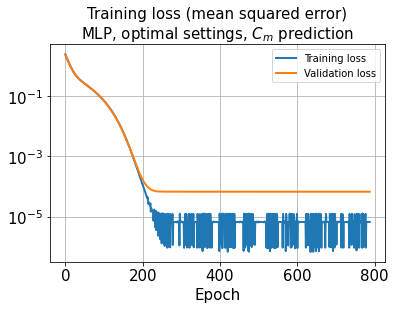

In [30]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

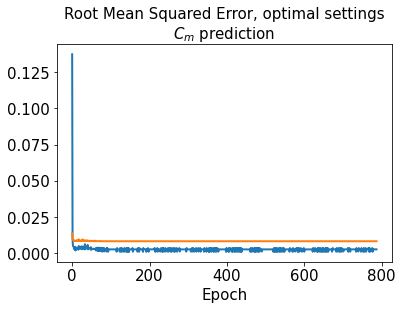

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

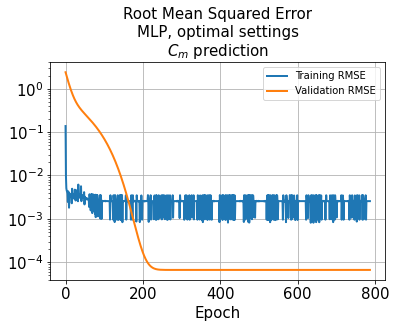

In [32]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [33]:
train_results = model.evaluate(x_train, y_train)

1750/1750 [==============================] - 5s 3ms/step - loss: 6.4987e-06 - rmse: 0.0025


In [34]:
val_results = model.evaluate(x_val, y_val)

501/501 [==============================] - 1s 3ms/step - loss: 6.7024e-05 - rmse: 0.0082


In [35]:
test_results = model.evaluate(x_test, y_test)

250/250 [==============================] - 1s 3ms/step - loss: 6.7834e-07 - rmse: 8.2361e-04


In [36]:
cm

array([[0.038717  ],
       [0.038266  ],
       [0.037764  ],
       ...,
       [0.0093676 ],
       [0.0080793 ],
       [0.00611161]])

In [37]:
x_train

array([[ 1.20440000e+01,  6.66666667e-01,  5.00000000e-01, ...,
        -1.20000000e-02, -8.00000000e-03, -4.00000000e-03],
       [ 1.29210000e+01,  1.00000000e+00,  6.66666667e-01, ...,
        -3.15193193e-03, -2.10128796e-03, -1.05064398e-03],
       [ 1.17830000e+01,  3.33333333e-01,  6.66666667e-01, ...,
         1.36743824e-02,  9.11625495e-03,  4.55812748e-03],
       ...,
       [ 1.46140000e+01,  6.66666667e-01,  1.00000000e+00, ...,
        -1.80000000e-02, -1.20000000e-02, -6.00000000e-03],
       [ 1.17030000e+01,  3.33333333e-01,  3.33333333e-01, ...,
         1.36743824e-02,  9.11625495e-03,  4.55812748e-03],
       [ 1.20320000e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [38]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

250/250 [==============================] - 0s 1ms/step


In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [50]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [51]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [43]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221218unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [46]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [53]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.9630898485372464
654.4857255095709


In [ ]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

In [ ]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

In [ ]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [ ]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [ ]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [ ]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [ ]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [ ]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [ ]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
         l2_error_train*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

In [ ]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predicted = model.predict(x)

In [ ]:
np.max(x)

In [ ]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [ ]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k, index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [ ]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [ ]:
decoded_val

In [ ]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.01])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [ ]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 75, 75, 75]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_true = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_true, tTrain, tTest, iTrain, iTest)